In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
%matplotlib inline

# Load and check the data

In [2]:
X_full = np.load('./X_train.npy') # Feature description of training sample objects
Y_full = np.load('./y_train.npy') # Target variable values on the training sample
print('Dataset shape: {}\nTarget vector shape: {}'.format(X_full.shape, Y_full.shape))
print('X:', X_full[0:5])
print('Y:', Y_full[0:5])

Dataset shape: (10000, 4)
Target vector shape: (10000, 1)
X: [[  -1.37985929   -1.6392424     1.90401167   -2.62726819]
 [  -5.41159781   -5.49543837   29.28539091 -158.48075746]
 [  -4.29978581   -4.59480326   18.48815797  -79.49511923]
 [  -6.00513656   -5.9213484    36.06166512 -216.55522367]
 [  -6.4203386    -6.36417221   41.22074779 -264.65115829]]
Y: [[2.46862556]
 [9.99814558]
 [9.27899993]
 [8.63480621]
 [9.56711056]]


Let's check the features for correlation

[]

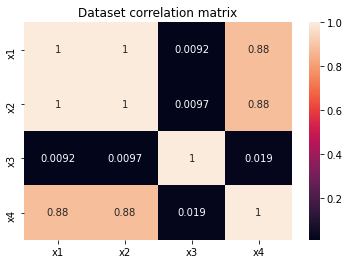

In [3]:
df = pd.DataFrame(data = X_full, columns = ['x1', 'x2', 'x3', 'x4'])
corr_matrix = df.corr() # compute correlation matrix
sns.heatmap(corr_matrix, annot = True)
plt.title('Dataset correlation matrix')
plt.plot()

As we can see, features __x1__ and __x2__ are _linearly dependent_    
and __x4__ is _strongly correlated_ with __x1__  
Thus we can _remove_ __x1__ from our dataset.  
Also we can remove __x4__, but I'll do it just to visualize data

Divide our dataset into __training set__, __cross-validation set__, and __test set__    
__X_train__ - training set  
__X_valid__ - cross-validation set  
__X_test__ - test set  
10 % of __X_full__ goes to cross-validation set, the same with test set  
We do the same with __Y_full__.

In [4]:
m = X_full.shape[0] # number of training examples
# We'll copy original dataset to avoid changing it
# 80% to training set
cut1 = np.floor(m * 0.8).astype('int64') # train / cross-valid. sets
cut2 = cut1 + (m - cut1)//2              # cross-valid. / test sets 
# Also we remove feature #1 from the dataset
X_train = X_full[:cut1, 1:].copy()
Y_train = Y_full[:cut1].copy()
# 10% to cross-valid. set
X_valid = X_full[cut1:cut2, 1:].copy()
Y_valid = Y_full[cut1:cut2].copy()
# 10% to test set
X_test = X_full[cut2:, 1:].copy()
Y_test = Y_full[cut2:].copy()

# Check that we have divided everything correctly:
is_correct = (m == (X_train.shape[0] + X_valid.shape[0] + X_test.shape[0]))
print('Division is correct: {}\n'.format(is_correct))
print('X_train shape: {}\nX_valid shape: {}\nX_test shape:  {}'.format(X_train.shape, X_valid.shape, X_test.shape))

Division is correct: True

X_train shape: (8000, 3)
X_valid shape: (1000, 3)
X_test shape:  (1000, 3)


# Visualize data
Distributions of features and target values

I plot __x2__ and __x4__ joint distribution, because they're strongly correlated

<Figure size 432x288 with 0 Axes>

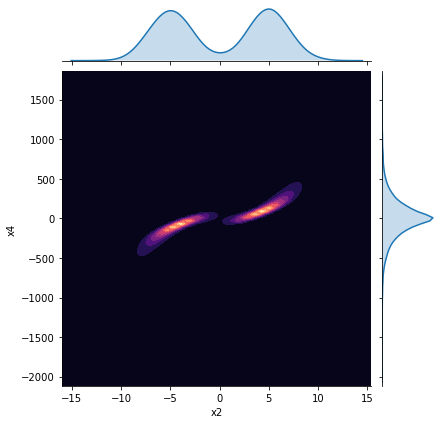

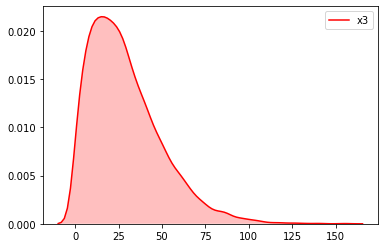

In [5]:
plt.figure()
sns.jointplot(x=df['x2'], y=df['x4'], kind="kde", cmap = 'magma')
plt.figure()
sns.kdeplot(data = df['x3'], shade=True, color = 'r')
plt.show()

Plotting target values

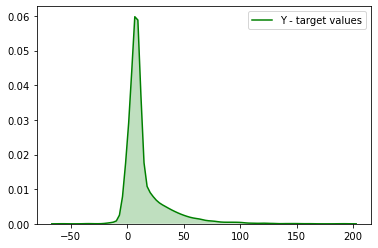

In [6]:
plt.figure()
sns.kdeplot(data = pd.DataFrame(data = Y_full, columns = ['Y - target values'])['Y - target values'],shade = True, color = 'g')
plt.show()

Plot Y(x2, x3), I removed __x4__, because it's highly correlated with __x2__

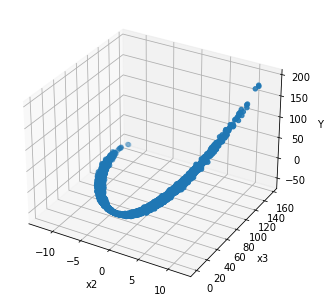

In [7]:
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure()

ax = Axes3D(fig)

x_vals = df['x2']
y_vals = df['x3']
z_vals = Y_full

ax.scatter(x_vals, y_vals, z_vals)

ax.set_xlabel('x2')
ax.set_ylabel('x3')
ax.set_zlabel('Y')

plt.show()

We can see that relationships between features and target values are nonlinear,  
thus we need to add some polynomial features

# Adding polynomial features

We'll use _scikit-learn_ to add some polynomial features  
also it will add bias to our dataset

In [8]:
from sklearn.preprocessing import PolynomialFeatures

def add_poly(X, degree = 2, inter = False):
    
    poly = PolynomialFeatures(degree = degree, interaction_only = inter)
    
    return poly.fit_transform(X)

# Building a model
#### Implement linear regression
$h_\theta(x)$ is a linear function of $\theta$  
We will use the next loss function (_m_ is a number of training examples)   
1. $\mathcal{L} = \frac{1}{2m}\displaystyle\sum_{i=1}^{m}(h_{\theta}(x^{(i)}) - y^{(i)})^2$    
2. $\frac{\partial\mathcal{L}}{\partial\theta_j} = \frac{1}{m}(\displaystyle\sum_{i=1}^{m}(h_{\theta}(x^{(i)}) - y^{(i)})x_j$  
3. $\theta_j = \theta_j - \alpha\frac{\partial\mathcal{L}}{\partial\theta_j}$ where $\alpha$ is _learning rate_,  
    all parameters are updated _simultaneously_
      
also instead of $x_j$ in (2), you can pass $f(x_j)$, if you have some function of $x_j$ as your feature

#### Training loop

1. Initialize hyperparameters  
_Go inside training loop_ 
2. for i in # epochs:  
    - Compute target values $\widehat{y} = h_{\theta}(x^{(i)})$  
    - Compute cost $\mathcal{L} = \frac{1}{2m}\displaystyle\sum_{i=1}^{m}(h_{\theta}(x^{(i)}) - y^{(i)})^2$  
    - Compute gradients $\frac{\partial\mathcal{L}}{\partial\theta_j} = \frac{1}{m}(\displaystyle\sum_{i=1}^{m}(h_{\theta}(x^{(i)}) - y^{(i)})x_j$  
    - Update parameters $\theta_j = \theta_j - \alpha\frac{\partial\mathcal{L}}{\partial\theta_j}$

In [9]:
class Differentiable:
    def __init__(self):
        pass
    
    def forward(self, **kwargs):
        raise NotImplementedError()
    
    def backward(self, **kwargs):
        raise NotImplementedError()

In [10]:
class loss(Differentiable):
    
    def __init__(self):
        super().__init__()
    
    def forward(self, y_pred, y_true):
        m = y_true.shape[0]
        
        loss_value = 1/(2*m) * np.sum((y_pred - y_true)**2)
        
        return loss_value
    
    def backward(self, y_pred, y_true):
        partial_grad = np.zeros_like(y_pred - y_true)
        
        partial_grad = 1/m * (y_pred - y_true)
        
        return partial_grad

In [11]:
class linear_regression(Differentiable):
    
    def __init__(self):
        super().__init__()
        self.theta = None
    
    def __call__(self, X):
        return self.forward(X)
    
    def backward(self, X):
        
        partial_grad = X.T
        return partial_grad
        
    def forward(self, X):
        
        assert X.ndim == 2, "X should be 2-dimensional: (m of objects, n of features)"
        
        if self.theta is None:
            
            self.theta = np.zeros((X.shape[1], 1))
           
       
        y_pred = np.dot(X, self.theta)
        
        return y_pred

We will estimate accuracy by computing _Mean Absolute Error_  
error = $\frac{1}{m}\displaystyle\sum_{i=1}^{m}|(\widehat{y^{(i)}} - y^{(i)})|$

In [12]:
def predict_err(X, y, model):
    """
    Compute Mean Absolute Error (MAE)
    
    Returns:
    Prediction error, calculated by MAE
    """
    y_pred = model.forward(X)
    error = 1/X.shape[0] * np.sum(np.abs(y-y_pred))
    
    return error

In [13]:
def plot_cost(DataSet, loss_history, loss_valid_history, model, learning_rate = 0.001):
    """
    Plot loss function
    
    Arguments:
    loss_history -- list of tuples = [...(loss_value, error_value)...] on training set
    loss_valid_history -- list of tuples = [...(loss_value, error_value)...] on cross-validation set
    """
    # Plot loss function
    plt.figure()
    plt.plot(loss_valid_history[:,0], label = 'Dev set')
    plt.plot(loss_history[:,0], label = 'Training set')
    plt.title('Cost with learning rate = {}'.format(learning_rate))
    plt.ylabel('Loss')
    plt.xlabel('Epochs')
    plt.legend()
    # Plot error
    plt.figure()
    plt.plot(loss_valid_history[:, 1], label = 'Dev set')
    plt.plot(loss_history[:, 1], label = 'Training set')
    plt.title('Prediction error')
    plt.ylabel('Error')
    plt.xlabel('Epochs')
    plt.legend()
    
    (x_train, y_train, x_valid, y_valid) = DataSet

    print('Prediction error on training set: {}'.format(predict_err(x_train, y_train, model)))
    print('Prediction error on cross-validation set: {}'.format(predict_err(x_valid, y_valid, model)))
    print('Parameters: {}'.format(model.theta))

In [14]:
def train_loop(X, y, X_valid, y_valid, model, loss_fn, epochs = 100, lr_rate = 0.001):
    loss_history = list()
    loss_valid_history = list()
    pbar = tqdm(total = epochs)
    
    
    for epoch in range(epochs):
        
        y_pred = model.forward(X)
        y_pred_valid = model.forward(X_valid)
        
        loss_value = (loss_fn.forward(y_pred, y), predict_err(X, y, model))
        loss_value_valid = (loss_fn.forward(y_pred_valid, y_valid), predict_err(X_valid, y_valid, model))
        grad = np.dot(model.backward(X), loss_fn.backward(y_pred, y)) 
        model.theta = model.theta - lr_rate*grad
        
        loss_history.append(loss_value)
       # if (epoch % 100 == 0):
        #    print('Training cost after {} epochs: {}'.format(epoch, loss_value))
        loss_valid_history.append(loss_value_valid)
        pbar.update(1)
        pbar.set_postfix({'loss': loss_value[0]})
        
    pbar.close()
    return np.array(loss_history), np.array(loss_valid_history)

# Fitting the model

We'll try different combinations of learning rates, polynomial degrees, numbers of epochs and choose the best.

### First attempt

In [15]:
loss_fn_1 = loss()
lr_model_1 = linear_regression()
lr_rate_1 = 0.00001 # learning rate

# Add bias to datasets
X_train_1 = add_poly(X_train, degree = 1)
X_valid_1 = add_poly(X_valid, degree = 1)

loss_history_1, loss_valid_history_1 = train_loop(X_train_1, Y_train, X_valid_1, Y_valid, lr_model_1, loss_fn_1, lr_rate = lr_rate_1, epochs = 1000)

100%|████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 362.15it/s, loss=6.07]


Prediction error on training set: 3.000566011799045
Prediction error on cross-validation set: 3.791879068286683
Parameters: [[ 0.01258013]
 [-0.07173834]
 [ 0.51820141]
 [ 0.05674478]]


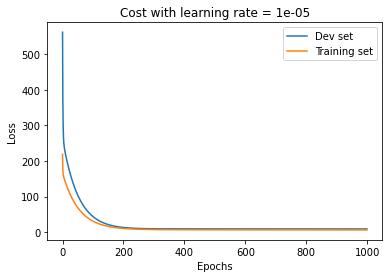

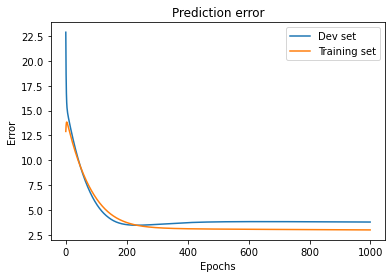

In [16]:
DataSet = (X_train_1, Y_train, X_valid_1, Y_valid)
plot_cost(DataSet, loss_history_1, loss_valid_history_1, lr_model_1, lr_rate_1)

### Conclusion
Due to strong difference between errors of training set and dev set, we have a problem of _overfitting_  .  
This can be solved with getting more training data,
but stop gradient descent a bit earlier will also be helpfull  
Stopping after ~250 epochs may prevent overfitting.

100%|██████████████████████████████████████████████████████████| 250/250 [00:00<00:00, 453.98it/s, loss=7.96]


Prediction error on training set: 3.3808323999444423
Prediction error on cross-validation set: 3.4793084180529923
Parameters: [[ 0.01104416]
 [-0.01924952]
 [ 0.4696391 ]
 [ 0.05424942]]


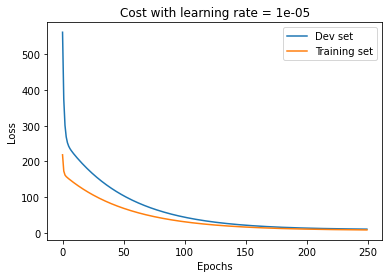

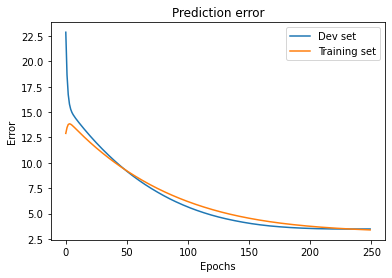

In [17]:
loss_fn_1 = loss()
lr_model_1 = linear_regression()

loss_history_1, loss_valid_history_1 = train_loop(X_train_1, Y_train, X_valid_1, Y_valid, lr_model_1, loss_fn_1, lr_rate = lr_rate_1, epochs = 250)
plot_cost(DataSet, loss_history_1, loss_valid_history_1, lr_model_1, lr_rate_1)

### Let's add poly features

100%|█████████████████████████████████████████████████████| 250/250 [00:00<00:00, 434.26it/s, loss=2.57e+122]


Prediction error on training set: 1.495396420806345e+61
Prediction error on cross-validation set: 1.6157674077259e+61
Parameters: [[-4.35495411e+50]
 [ 8.08787099e+50]
 [-2.96229022e+52]
 [ 5.44821209e+52]
 [ 5.44474121e+52]
 [-2.35755050e+54]
 [ 4.28856076e+54]
 [-2.13682136e+56]]


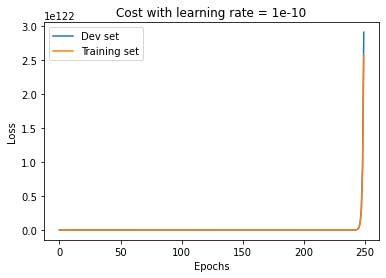

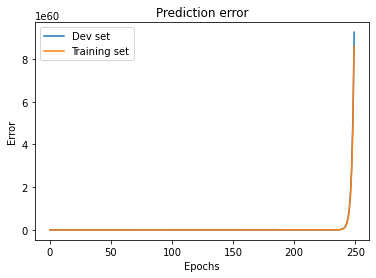

In [18]:
loss_fn_2 = loss()
lr_model_2 = linear_regression()
lr_rate_2 = 1e-10 # learning rate
# degree = 2 by default
X_train_2 = add_poly(X_train, degree = 5, inter = True)
X_valid_2 = add_poly(X_valid, degree = 5, inter = True)

loss_history_2, loss_valid_history_2 = train_loop(X_train_2, Y_train, X_valid_2, Y_valid, lr_model_2, loss_fn_2, lr_rate = lr_rate_2, epochs = 250)

DataSet = (X_train_2, Y_train, X_valid_2, Y_valid)
plot_cost(DataSet, loss_history_2, loss_valid_history_2, lr_model_2, lr_rate_2)

### Conclusion
I've tried all degrees from 1 to 10, and the best perfomance was given by degree = 1 (original set)  

We can compute relative error in the next way:  
$\varepsilon = \frac{\frac{1}{m}\displaystyle\sum_{i=1}^{m}|(\widehat{y^{(i)}} - y^{(i)})|}{\frac{1}{m}\displaystyle\sum_{i=1}^{m}y^{(i)}}$

In [19]:
y_mean_train = np.mean(Y_train)
y_mean_valid = np.mean(Y_valid)
y_mean_test = np.mean(Y_test)

print('Training relative error: {} %'.format(100*predict_err(X_train_1, Y_train, lr_model_1) / y_mean_train))
print('Cross-validation relative error: {} %'.format(100*predict_err(X_valid_1, Y_valid, lr_model_1) / y_mean_valid))

Training relative error: 27.113884467258057 %
Cross-validation relative error: 15.38128967832007 %


In [20]:
Y_pred_valid = lr_model_1.forward(X_valid_1)
print('Predicted\n', Y_pred_valid[228:235])
print('Actual\n', Y_valid[228:235])

Predicted
 [[ 3.5318974 ]
 [34.99276796]
 [27.9232703 ]
 [72.99443099]
 [38.256768  ]
 [22.28104325]
 [81.19980859]]
Actual
 [[-0.3144147 ]
 [35.10526157]
 [25.223552  ]
 [83.02398444]
 [37.2137381 ]
 [20.88986307]
 [93.6305927 ]]


Let's check values that are close to mean

In [21]:
print('Predicted\n', Y_pred_valid[((20<Y_pred_valid)&(Y_pred_valid<60))][5:10])
print('Actual\n', Y_valid[((20<Y_pred_valid)&(Y_pred_valid<60))][5:10])

Predicted
 [26.0106156  34.61136478 43.67784252 30.53935836 20.44260783]
Actual
 [23.29463434 34.93137138 45.71239096 30.04554769 18.14081554]


It seems that the biggest error is obtained at small target values  
Compute _MAE_ on each interval in intervals to check the hypothesis

In [22]:
X_test_1 = add_poly(X_test, degree = 1)
print('Mean train: {}, Mean dev: {}, Mean test: {}'.format(y_mean_train, y_mean_valid, y_mean_test))
# Check MAE on each interval
intervals = [(-5, 0), (0, 5), (5,10), (10,20), (20,50), (50, 100), (100,200)]
for interval in intervals:
    print('--------------------')
    print('Errors on Y from {}'.format(interval))
    # MAE on each interval of each set
    mae_train = predict_err(X_train_1[np.squeeze(((interval[0]<Y_train)&(Y_train<interval[1])))],Y_train[((interval[0]<Y_train)&(Y_train<interval[1]))].reshape((Y_train[((interval[0]<Y_train)&(Y_train<interval[1]))].shape[0], 1)), lr_model_1)
    mae_valid = predict_err(X_valid_1[np.squeeze(((interval[0]<Y_valid)&(Y_valid<interval[1])))],Y_valid[((interval[0]<Y_valid)&(Y_valid<interval[1]))].reshape((Y_valid[((interval[0]<Y_valid)&(Y_valid<interval[1]))].shape[0], 1)), lr_model_1)
    mae_test = predict_err(X_test_1[np.squeeze(((interval[0]<Y_test)&(Y_test<interval[1])))],Y_test[((interval[0]<Y_test)&(Y_test<interval[1]))].reshape((Y_test[((interval[0]<Y_test)&(Y_test<interval[1]))].shape[0], 1)), lr_model_1)
    # Relative error on each interval of each set
    rel_train = 100*mae_train/np.abs(np.mean(Y_train[((interval[0]<Y_train)&(Y_train<interval[1]))].reshape((Y_train[((interval[0]<Y_train)&(Y_train<interval[1]))].shape[0], 1))))
    rel_valid = 100*mae_valid/np.abs(np.mean(Y_valid[((interval[0]<Y_valid)&(Y_valid<interval[1]))].reshape((Y_valid[((interval[0]<Y_valid)&(Y_valid<interval[1]))].shape[0], 1))))
    rel_test = 100*mae_test/np.abs(np.mean(Y_test[((interval[0]<Y_test)&(Y_test<interval[1]))].reshape((Y_test[((interval[0]<Y_test)&(Y_test<interval[1]))].shape[0], 1))))
    print('Train MAE', mae_train, 'Relative', rel_train, '%')
    print('Dev MAE', mae_valid, 'Relative', rel_valid, '%')
    print('Test MAE', mae_test, 'Relative', rel_test, '%')

Mean train: 12.469007913738947, Mean dev: 22.62039458860903, Mean test: 22.906568874368265
--------------------
Errors on Y from (-5, 0)
Train MAE 2.5102825472684156 Relative 185.9320014586678 %
Dev MAE 3.2067625189490605 Relative 229.22789015107347 %
Test MAE 2.967428275244282 Relative 235.08686096042442 %
--------------------
Errors on Y from (0, 5)
Train MAE 2.2609469731826692 Relative 78.796300434432 %
Dev MAE 3.8793327637262167 Relative 156.9230527746052 %
Test MAE 3.834080588208644 Relative 177.3990740843981 %
--------------------
Errors on Y from (5, 10)
Train MAE 3.6872305524715596 Relative 46.04049726449495 %
Dev MAE 3.8540551415888986 Relative 51.69354570999668 %
Test MAE 3.8533315729544197 Relative 51.476069710249405 %
--------------------
Errors on Y from (10, 20)
Train MAE 3.960435143484001 Relative 30.117590603184055 %
Dev MAE 3.1728640206875833 Relative 21.453781969573292 %
Test MAE 3.1239284753494343 Relative 20.844436925171426 %
--------------------
Errors on Y from (2

# Final
As we can see this linear model  

$h_\theta(x) = \theta_0 x_0 + \theta_1 x_2 + \theta_2 x_3 + \theta_3 x_4$  
(__x0__ = 1, __x2__, __x3__, __x4__ are the features of the original dataset __X_full__)  

performs not very well on this dataset, it shows itself good on the data to which target values Y from the interval (20, 50) corresponds. On the rest, the error increases, the largest error is achieved on Y from interval (-5, 5). When using gradient descent, _overfitting_ appears after ~250 iterations, it was prevented by _early stopping_, but having more data also would improve this, that means this data is not enough. We encounter _underfitting_ on the traget values that are close to 0.

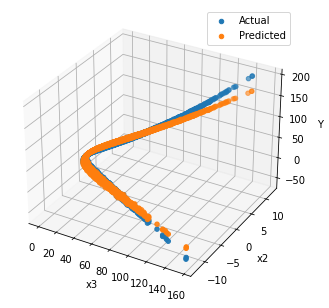

Parameters: [[ 0.01104416]
 [-0.01924952]
 [ 0.4696391 ]
 [ 0.05424942]]
Prediction error on test set: 3.308960191700947
Test relative error: 14.445464136724421 %


In [23]:
# Add bias to X_full and remove x1
X = add_poly(X_full[:, 1:], degree = 1)
Y = lr_model_1.forward(X)

fig2 = plt.figure()

ax2 = Axes3D(fig2)

x_vals = df['x3']
y_vals = df['x2']
z_vals = Y_full

ax2.scatter(x_vals, y_vals, z_vals, label = 'Actual')
ax2.scatter(x_vals, y_vals, Y, label = 'Predicted')


ax2.set_xlabel('x3')
ax2.set_ylabel('x2')
ax2.set_zlabel('Y')
plt.legend()
plt.show()

parameters = lr_model_1.theta
print('Parameters: {}'.format(parameters))
print('Prediction error on test set: {}'.format(predict_err(X_test_1, Y_test, lr_model_1)))
print('Test relative error: {} %'.format(100*predict_err(X_test_1, Y_test, lr_model_1) / y_mean_test))